In [48]:
import os 
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root) 

from src.model_utils import trainModel,tuneModel, save_params_to_json,saveModel
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from src.eval_metric import Metric
from src.preprocessor_utils import split_data
from src.pipeline_imbalanced import smote_pipeline


In [17]:
import nltk

# Tải gói 'popular' bao gồm: punkt, stopwords, wordnet, averaged_perceptron_tagger, v.v.
nltk.download('popular', quiet=True)

# Tải gói punkt_tab (bắt buộc cho các phiên bản NLTK mới, thường bị bỏ qua bởi gói popular)
nltk.download('punkt_tab', quiet=True)


True

In [18]:
path_train = 'D:\PythonLearn\workspace\Test\KPDL_1\data\data_train.csv'
path_test = 'D:\PythonLearn\workspace\Test\KPDL_1\data\data_test.csv'


In [19]:
d_train = pd.read_csv(path_train)
d_test = pd.read_csv(path_test)
    

In [20]:
import joblib
x = 'D:\PythonLearn\workspace\Test\KPDL_1\models\Preprocess_count_data.pkl'
preprocess = joblib.load(x)
X_train = preprocess[0]
Y_train = preprocess[1]

In [21]:
cont_pipeline = 'D:\\PythonLearn\\workspace\\Test\\KPDL_1\\models\\Preprocess_count_pipeline.pkl'
preprocess_2 = joblib.load(cont_pipeline)

In [22]:
X_test, Y_test = split_data(d_test)

In [23]:
x_test = preprocess_2.transform(X_test)


In [24]:
model = trainModel(X_train, Y_train, model_name='rf')


Training RF......
Train successful


In [27]:
eval_model=Metric(model, x_test, Y_test)

--- ĐÁNH GIÁ: RF (Threshold=0.25) ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.95      0.81      0.88       173

    accuracy                           0.99      3576
   macro avg       0.97      0.90      0.93      3576
weighted avg       0.99      0.99      0.99      3576

ROC-AUC: 0.9879
PR-AUC (AUPRC): 0.9408 (Quan trọng cho Fraud)


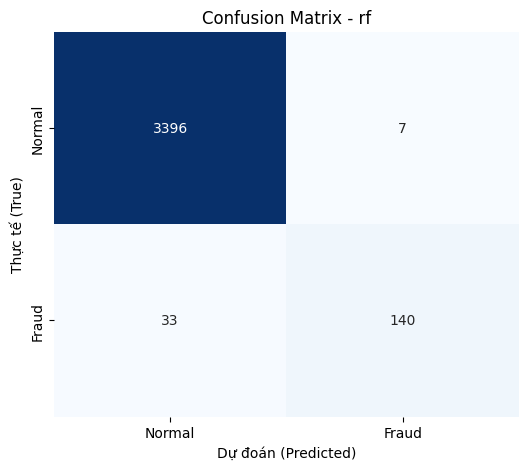

In [31]:
eval_model.evaluate_model('rf', 0.25)


In [33]:
param_rcv = {
    "n_estimators": [200,300,500],
    "max_features": ["sqrt", "log2"],
    "criterion": ["gini", "entropy"],
    "min_samples_split": [5, 8, 10],
    "min_samples_leaf": [2, 4, 8],
    "max_depth": [10, 20, 30]
}

In [35]:
model_tuned = tuneModel(X_train, Y_train, model_name='rf', raw_params=param_rcv,name_search="rcv",n_iter = 50)

---------Starting Tuning RF-------------
Fitting 5 folds for each of 50 candidates, totalling 250 fits
=======result tune============
Best params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'entropy'}
Best f1: 0.6069


In [42]:
param_gcv = {
    "n_estimators": [300],
    "max_features": ["sqrt"],
    "criterion": ["entropy"],
    "min_samples_split": [3, 5, 7],
    "min_samples_leaf": [2, 4, 8],
    "max_depth": [20, 30, 35]
}

In [43]:
model_tuned = tuneModel(X_train, Y_train, model_name='rf', raw_params=param_gcv,name_search="gcv")

---------Starting Tuning RF-------------
Fitting 5 folds for each of 27 candidates, totalling 135 fits
=======result tune============
Best params: {'criterion': 'entropy', 'max_depth': 35, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 300}
Best f1: 0.6273


--- ĐÁNH GIÁ: RF (Threshold=0.35) ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.99      0.72      0.84       173

    accuracy                           0.99      3576
   macro avg       0.99      0.86      0.91      3576
weighted avg       0.99      0.99      0.99      3576

ROC-AUC: 0.9879
PR-AUC (AUPRC): 0.9408 (Quan trọng cho Fraud)


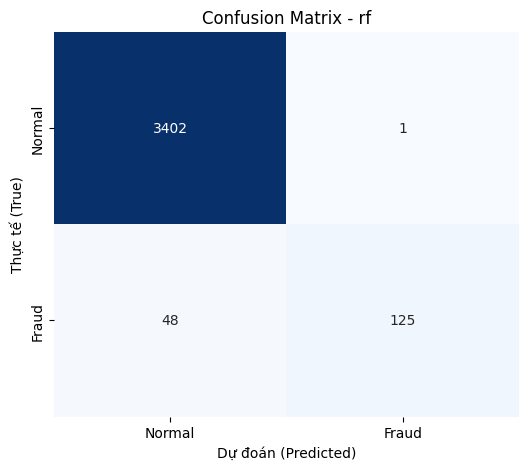

In [46]:
eval_model.evaluate_model('rf', 0.35)


In [49]:
X_smote, Y_smote = smote_pipeline(X_train, Y_train)
model_smote = trainModel(X_smote, Y_smote, model_name='rf')

Training RF......
Train successful


--- ĐÁNH GIÁ: RF (Threshold=0.35) ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.99      0.72      0.84       173

    accuracy                           0.99      3576
   macro avg       0.99      0.86      0.91      3576
weighted avg       0.99      0.99      0.99      3576

ROC-AUC: 0.9879
PR-AUC (AUPRC): 0.9408 (Quan trọng cho Fraud)


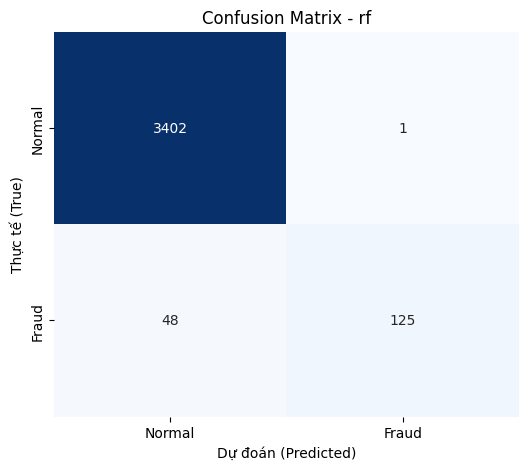

In [50]:
eval_model.evaluate_model('rf', 0.35)

In [ ]:
y = 'D:\PythonLearn\workspace\Test\KPDL_1\models\Preprocess_tfidf_data.pkl'
preprocess = joblib.load(y)
X_train_tfidf = preprocess[0]
Y_train = preprocess[1]

In [ ]:
tfidf_pipeline = 'D:\PythonLearn\workspace\Test\KPDL_1\models\Preprocess_tfidf_pipeline.pkl'
preprocess_2 = joblib.load(tfidf_pipeline)